# 2025 NFL Schedule Prediction

### Goal: Create a model that succesfully predicts at least 60% correctly for the 2025 season

In [1]:

import nfl_data_py as nfl
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


# Use nfl_data_py to grab team schedule and play-by-play data

In [2]:
pbp = nfl.import_pbp_data([2023, 2024])
schedule = nfl.import_schedules([2023, 2024])

2023 done.
2024 done.
Downcasting floats.


In [3]:
pd.set_option('display.max_columns', None)
pbp.head()

,play_id,game_id,old_game_id_x,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,td_player_name,td_player_id,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,passing_yards,receiver_player_id,receiver_player_name,receiving_yards,rusher_player_id,rusher_player_name,rushing_yards,lateral_receiver_player_id,lateral_receiver_player_name,lateral_receiving_yards,lateral_rusher_player_id,lateral_rusher_player_name,lateral_rushing_yards,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_ta

In [4]:
schedule.head()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
6421,2023_01_DET_KC,2023,REG,1,2023-09-07,Thursday,20:20,DET,21.0,KC,20.0,Home,-1.0,41.0,0.0,2023090700,59173.0,NaN,202309070kan,NaN,401547353.0,NaN,7,7,164.0,-198.0,4.0,-110.0,-110.0,53.0,-110.0,-110.0,0,outdoors,NaN,NaN,NaN,00-0033106,00-0033873,Jared Goff,Patrick Mahomes,Dan Campbell,Andy Reid,John Hussey,KAN00,GEHA Field at Arrowhead Stadium
6422,2023_01_CAR_ATL,2023,REG,1,2023-09-10,Sunday,13:00,CAR,10.0,ATL,24.0,Home,14.0,34.0,0.0,2023091000,59174.0,NaN,202309100atl,NaN,401547403.0,NaN,7,7,160.0,-192.0,3.5,-108.0,-112.0,40.5,-110.0,-110.0,1,closed,NaN,NaN,NaN,00-0039150,00-0038122,Bryce Young,Desmond Ridder,Frank Reich,Arthur Smith,Brad Rogers,ATL97,Mercedes-Benz Stadium
6423,2023_01_HOU_BAL,2023,REG,1,2023-09-10,Sunday,13:00,HOU,9.0,BAL,25.0,Home,16.0,34.0,0.0,2023091001,59175.0,NaN,202309100rav,NaN,401547396.0,NaN,7,7,380.0,-500.0,9.5,-110.0,-110.0,43.5,-110.0,-110.0,0,outdoors,NaN,NaN,NaN,00-0039163,00-0034796,C.J. Stroud,Lamar Jackson,DeMeco Ryans,John Harbaugh,Tra Blake,BAL00,M&T Bank Stadium
6424,2023_01_CIN_CLE,2023,REG,1,2023-09-10,Sunday,13:00,CIN,3.0,CLE,24.0,Home,21.0,27.0,0.0,2023091002,59176.0,NaN,202309100cle,NaN,401547397.0,NaN,7,7,-112.0,-108.0,-1.0,-105.0,-115.0,46.5,-110.0,-110.0,1,outdoors,NaN,NaN,NaN,00-0036442,00-0033537,Joe Burrow,Deshaun Watson,Zac Taylor,Kevin Stefanski,Clete Blakeman,CLE00,FirstEnergy Stadium
6425,2023_01_JAX_IND,2023,REG,1,2023-09-10,Sunday,13:00,JAX,31.0,IND,21.0,Home,-10.0,52.0,0.0,2023091003,59177.0,NaN,202309100clt,NaN,401547404.0,NaN,7,7,-205.0,170.0,-4.0,-108.0,-112.0,45.5,-110.0,-110.0,1,closed,NaN,NaN,NaN,00-0036971,00-0039164,Trevor Lawrence,Anthony Richardson,Doug Pederson,Shane Steichen,Clay Martin,IND00,Lucas Oil Stadium


### Aggregate Team-Level Stats

In [5]:
team_stats = pbp.groupby(['game_id', 'posteam']).agg({
'yards_gained': 'sum',
'epa': 'mean',
'pass_attempt': 'sum',
'rush_attempt': 'sum',
'touchdown': 'sum',
'interception': 'sum',
'third_down_converted': 'sum',
'third_down_failed': 'sum'
}).reset_index()

In [6]:
# Creating third_down_pct feature
team_stats['third_down_pct'] = (
team_stats['third_down_converted'] /(team_stats['third_down_converted'] + team_stats['third_down_failed'].replace(0, np.nan))
)

team_stats.head()

,game_id,posteam,yards_gained,epa,pass_attempt,rush_attempt,touchdown,interception,third_down_converted,third_down_failed,third_down_pct
0,2023_01_ARI_WAS,ARI,210.0,-0.250087,33.0,25.0,0.0,0.0,4.0,10.0,0.285714
1,2023_01_ARI_WAS,WAS,248.0,-0.199550,37.0,28.0,3.0,1.0,4.0,8.0,0.333333
2,2023_01_BUF_NYJ,BUF,314.0,-0.113804,46.0,22.0,2.0,3.0,5.0,8.0,0.384615
3,2023_01_BUF_NYJ,NYJ,289.0,-0.015500,25.0,28.0,1.0,1.0,5.0,8.0,0.384615
4,2023_01_CAR_ATL,ATL,221.0,-0.064488,22.0,26.0,3.0,0.0,2.0,8.0,0.200000


### Create Win/Loss Table

##### Create a Binary Label for the win column (1 = Win, 0 = Loss). This is our target variable

In [7]:
schedule = schedule[['game_id', 'home_team', 'away_team', 'home_score', 'away_score']]
schedule = schedule.dropna()

home = schedule[['game_id', 'home_team', 'home_score', 'away_score']].copy()
home.columns = ['game_id', 'team', 'score', 'opp_score']
away = schedule[['game_id', 'away_team', 'away_score', 'home_score']].copy()
away.columns = ['game_id', 'team', 'score', 'opp_score']
results = pd.concat([home, away])
results['win'] = (results['score'] > results['opp_score']).astype(int)

In [8]:
results.head()

,game_id,team,score,opp_score,win
6421,2023_01_DET_KC,KC,20.0,21.0,0
6422,2023_01_CAR_ATL,ATL,24.0,10.0,1
6423,2023_01_HOU_BAL,BAL,25.0,9.0,1
6424,2023_01_CIN_CLE,CLE,24.0,3.0,1
6425,2023_01_JAX_IND,IND,21.0,31.0,0


### Merge Stats & Labels

In [9]:
df = pd.merge(team_stats, results, left_on=['game_id', 'posteam'], right_on=['game_id', 'team'])
df = df.drop(columns=['team'])
df = df.dropna()
df.head()

,game_id,posteam,yards_gained,epa,pass_attempt,rush_attempt,touchdown,interception,third_down_converted,third_down_failed,third_down_pct,score,opp_score,win
0,2023_01_ARI_WAS,ARI,210.0,-0.250087,33.0,25.0,0.0,0.0,4.0,10.0,0.285714,16.0,20.0,0
1,2023_01_ARI_WAS,WAS,248.0,-0.199550,37.0,28.0,3.0,1.0,4.0,8.0,0.333333,20.0,16.0,1
2,2023_01_BUF_NYJ,BUF,314.0,-0.113804,46.0,22.0,2.0,3.0,5.0,8.0,0.384615,16.0,22.0,0
3,2023_01_BUF_NYJ,NYJ,289.0,-0.015500,25.0,28.0,1.0,1.0,5.0,8.0,0.384615,22.0,16.0,1
4,2023_01_CAR_ATL,ATL,221.0,-0.064488,22.0,26.0,3.0,0.0,2.0,8.0,0.200000,24.0,10.0,1


### Feature Engineering

In [10]:
features = [
    'yards_gained', 'epa', 'pass_attempt', 'rush_attempt',
    'touchdown', 'interception', 'third_down_pct']
X = df[features]
y = df['win']

### Train/Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train XGBoost Model

In [12]:
model = xgb.XGBClassifier(
n_estimators=150,
learning_rate=0.1,
max_depth=4,
use_label_encoder=False,
eval_metric='logloss',
random_state=42
)
model.fit(X_train, y_train)

c:\Users\Garrett\Documents\Data Science\2025 NFL Schedule Predictor\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:27:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

In [13]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [14]:
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7807017543859649
ROC AUC Score: 0.8639162561576353

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.71      0.76       112
           1       0.75      0.85      0.80       116

    accuracy                           0.78       228
   macro avg       0.79      0.78      0.78       228
weighted avg       0.79      0.78      0.78       228



### Key Metrics
##Accuracy: 0.78

This means the model correctly predicted the outcome of 78% of the games in the test set.

Accuracy is a good general metric, but it can be misleading if classes are imbalanced (e.g., more wins than losses).

## ROC AUC Score: 0.86

This score measures how well the model separates the two classes (win vs. loss).

## A score of 0.86 indicates very good separation. A perfect model would score 1.0, and a random guess would score 0.5.

## Classification Report Breakdown
Metric	Class 0 (Loss)	Class 1 (Win)
Precision	0.82	0.75
Recall	0.71	0.85
F1-score	0.76	0.80
Support	112 games	116 games

## Precision:

For predicted losses, 82% were correct.

For predicted wins, 75% were correct.

## Recall:

The model correctly identified 71% of actual losses and 85% of actual wins.

This shows the model is slightly better at identifying wins than losses.

## F1-score:

A balance between precision and recall.

Higher for wins (0.80) than losses (0.76), meaning the model is more consistent when predicting a win.

🧠 Summary
The model performs well overall, with a solid balance between precision and recall.

The ROC AUC of 0.86 is especially strong—it shows the model confidently separates winners from losers.

Slightly better at predicting wins than losses, but both classes are handled reasonably well.

### Create Rolling Averages for Teams (using data from 2023-2024)

In [15]:
schedule_dates = schedule[['game_id', 'home_team', 'away_team']]
schedule_dates = pd.merge(schedule_dates, nfl.import_schedules([2023, 2024])[['game_id', 'gameday']], on='game_id')
schedule_dates = schedule_dates.rename(columns={'gameday': 'game_date'})

# Unpivot teams so each row is one team per game
home_dates = schedule_dates[['game_id', 'home_team', 'game_date']].rename(columns={'home_team': 'posteam'})
away_dates = schedule_dates[['game_id', 'away_team', 'game_date']].rename(columns={'away_team': 'posteam'})
team_dates = pd.concat([home_dates, away_dates])

# Merge dates into team_stats
team_stats = pd.merge(team_stats, team_dates, on=['game_id', 'posteam'])
team_stats['game_date'] = pd.to_datetime(team_stats['game_date'])

# Sort before applying rolling averages
team_stats = team_stats.sort_values(by=['posteam', 'game_date'])

# Now apply rolling average
team_rolling = team_stats.groupby('posteam')[features].rolling(window=5, min_periods=1).mean().reset_index()

In [16]:
team_rolling

,posteam,level_1,yards_gained,epa,pass_attempt,rush_attempt,touchdown,interception,third_down_pct
0,ARI,0,210.000000,-0.250087,33.000000,25.000000,0.0,0.0,0.285714
1,ARI,54,295.500000,-0.080426,32.000000,27.500000,1.5,0.0,0.342857
2,ARI,72,330.333333,0.017889,29.333333,28.666667,2.0,0.0,0.395238
3,ARI,96,338.250000,0.032917,32.500000,28.000000,2.0,0.0,0.429762
4,ARI,134,329.400000,-0.029619,33.000000,26.800000,2.4,0.4,0.416537
...,...,...,...,...,...,...,...,...,...
1135,WAS,1053,397.000000,0.062654,38.800000,33.400000,4.0,1.2,0.501120
1136,WAS,1113,368.000000,0.096338,38.000000,31.800000,4.0,0.8,0.526761
1137,WAS,1125,345.400000,0.096295,38.800000,29.400000,3.2,0.6,0.504857
1138,WAS,1133,376.400000,0.140329,37.200000,30.800000,3.8,0.6,0.465641


### Load 2025 Schedule

In [17]:
schedule_2025 = nfl.import_schedules([2025])

In [18]:
schedule_2025.head()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
6991,2025_01_DAL_PHI,2025,REG,1,2025-09-04,Thursday,20:20,DAL,NaN,PHI,NaN,Home,NaN,NaN,NaN,2025090400,NaN,NaN,202509040phi,NaN,NaN,NaN,7,7,260.0,-325.0,7.0,-110.0,-110.0,46.5,-110.0,-110.0,1,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,Brian Schottenheimer,Nick Sirianni,NaN,PHI00,Lincoln Financial Field
6992,2025_01_KC_LAC,2025,REG,1,2025-09-05,Friday,20:00,KC,NaN,LAC,NaN,Neutral,NaN,NaN,NaN,2025090500,NaN,NaN,202509050sdg,NaN,NaN,NaN,7,7,-148.0,124.0,-3.0,-105.0,-115.0,44.5,-110.0,-110.0,1,dome,matrixturf,NaN,NaN,NaN,NaN,NaN,NaN,Andy Reid,Jim Harbaugh,NaN,LAX01,SoFi Stadium
6993,2025_01_TB_ATL,2025,REG,1,2025-09-07,Sunday,13:00,TB,NaN,ATL,NaN,Home,NaN,NaN,NaN,2025090700,NaN,NaN,202509070atl,NaN,NaN,NaN,7,7,-125.0,105.0,-1.5,-115.0,-105.0,48.5,-110.0,-110.0,1,closed,fieldturf,NaN,NaN,NaN,NaN,NaN,NaN,Todd Bowles,Raheem Morris,NaN,ATL97,Mercedes-Benz Stadium
6994,2025_01_CIN_CLE,2025,REG,1,2025-09-07,Sunday,13:00,CIN,NaN,CLE,NaN,Home,NaN,NaN,NaN,2025090701,NaN,NaN,202509070cle,NaN,NaN,NaN,7,7,-250.0,200.0,-5.5,-110.0,-110.0,45.5,-110.0,-110.0,1,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,Zac Taylor,Kevin Stefanski,NaN,CLE00,FirstEnergy Stadium
6995,2025_01_MIA_IND,2025,REG,1,2025-09-07,Sunday,13:00,MIA,NaN,IND,NaN,Home,NaN,NaN,NaN,2025090702,NaN,NaN,202509070clt,NaN,NaN,NaN,7,7,-105.0,-115.0,1.5,-115.0,-105.0,45.5,-110.0,-110.0,0,closed,fieldturf,NaN,NaN,NaN,NaN,NaN,NaN,Mike McDaniel,Shane Steichen,NaN,IND00,Lucas Oil Stadium


### Generate Features for 2025 Matchups

In [19]:
for _, game in schedule_2025.iterrows():
    home_team = game['home_team']
    away_team = game['away_team']

###  latest rolling average stats for home/away teams

In [20]:
team_2025_features = []

for _, game in schedule_2025.iterrows():
    home_team = game['home_team']
    away_team = game['away_team']
    
    try:
        # Get latest rolling stats
        home_stats = team_rolling[team_rolling['posteam'] == home_team].iloc[-1][features]
        away_stats = team_rolling[team_rolling['posteam'] == away_team].iloc[-1][features]
        
        # Create a dict instead of Series to guarantee consistent keys
        game_features = {
            f'{f}_home': home_stats[f] for f in features
        }
        game_features.update({
            f'{f}_away': away_stats[f] for f in features
        })
        
        team_2025_features.append(game_features)
        
    except IndexError:
        print(f"Missing rolling stats for game: {home_team} vs {away_team}, skipping...")
        continue

In [21]:
X_2025 = pd.DataFrame(team_2025_features)

In [22]:
away_stats.info()

<class 'pandas.core.series.Series'>
Index: 7 entries, yards_gained to third_down_pct
Series name: 178
Non-Null Count  Dtype 
--------------  ----- 
7 non-null      object
dtypes: object(1)
memory usage: 412.0+ bytes


### Combine Stats for prediction

In [23]:
combined_stats = pd.concat([
    pd.Series(home_stats.values, index=[f'{f}_home' for f in features]),
    pd.Series(away_stats.values, index=[f'{f}_away' for f in features])
])
team_2025_features.append(combined_stats)

### Create DataFrame of Features for 2025 Predictions

In [24]:
team_2025_features

[{'yards_gained_home': 349.4,
  'epa_home': 0.08231632178649306,
  'pass_attempt_home': 29.6,
  'rush_attempt_home': 35.0,
  'touchdown_home': 3.6,
  'interception_home': 0.2,
  'third_down_pct_home': 0.30922078192234037,
  'yards_gained_away': 339.0,
  'epa_away': 0.00985807403922081,
  'pass_attempt_away': 33.2,
  'rush_attempt_away': 30.8,
  'touchdown_away': 2.0,
  'interception_away': 0.6,
  'third_down_pct_away': 0.4014005661010742},
 {'yards_gained_home': 350.4,
  'epa_home': 0.011552640795707702,
  'pass_attempt_home': 37.0,
  'rush_attempt_home': 26.0,
  'touchdown_home': 3.0,
  'interception_home': 1.2,
  'third_down_pct_home': 0.372192519903183,
  'yards_gained_away': 269.6,
  'epa_away': -0.018340761959552764,
  'pass_attempt_away': 31.8,
  'rush_attempt_away': 19.8,
  'touchdown_away': 2.8,
  'interception_away': 0.4,
  'third_down_pct_away': 0.32060607224702836},
 {'yards_gained_home': 392.4,
  'epa_home': 0.03368394288117997,
  'pass_attempt_home': 32.2,
  'rush_attempt_

In [25]:
X_2025 = pd.DataFrame(team_2025_features)

In [26]:
features

['yards_gained',
 'epa',
 'pass_attempt',
 'rush_attempt',
 'touchdown',
 'interception',
 'third_down_pct']

In [27]:
print(X_2025.head())
print(X_2025.columns.tolist())

   yards_gained_home  epa_home  pass_attempt_home  rush_attempt_home  \
0              349.4  0.082316               29.6               35.0   
1              350.4  0.011553               37.0               26.0   
2              392.4  0.033684               32.2               33.8   
3              269.0 -0.256056               41.2               23.4   
4              379.6 -0.000829               32.0               36.8   

   touchdown_home  interception_home  third_down_pct_home  yards_gained_away  \
0             3.6                0.2             0.309221              339.0   
1             3.0                1.2             0.372193              269.6   
2             2.6                1.2             0.452088              429.2   
3             1.2                2.2             0.296456              388.4   
4             3.2                1.4             0.425268              319.2   

   epa_away  pass_attempt_away  rush_attempt_away  touchdown_away  \
0  0.009858      

### Rebuilding Training Set

In [28]:
# Create home and away dataframes with features
home_df = df[df['posteam'] == df['posteam']].copy()
away_df = df.copy()

# Merge home and away stats for the same game
combined_games = pd.merge(
    df,
    df,
    on='game_id',
    suffixes=('_home', '_away')
)

# Only keep rows where the teams are opposing
combined_games = combined_games[combined_games['posteam_home'] != combined_games['posteam_away']]

# Drop duplicate matchups (each game appears twice, once per team order)
combined_games = combined_games.drop_duplicates(subset=['game_id'])

# Create final feature set
features_combined = []
for f in features:
    features_combined.append(f'{f}_home')
    features_combined.append(f'{f}_away')

X_combined = combined_games[[f'{f}_home' for f in features] + [f'{f}_away' for f in features]]
y_combined = combined_games['win_home']  

In [29]:
features_combined

['yards_gained_home',
 'yards_gained_away',
 'epa_home',
 'epa_away',
 'pass_attempt_home',
 'pass_attempt_away',
 'rush_attempt_home',
 'rush_attempt_away',
 'touchdown_home',
 'touchdown_away',
 'interception_home',
 'interception_away',
 'third_down_pct_home',
 'third_down_pct_away']

### Retrain Model

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=4,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

c:\Users\Garrett\Documents\Data Science\2025 NFL Schedule Predictor\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:27:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

### Make Predictions for 2025 Games

In [31]:
predictions = model.predict(X_2025)
probabilities = model.predict_proba(X_2025)[:, 1]

### Show Predictions

In [32]:
valid_games = []  # track which games have valid rolling stats

for _, game in schedule_2025.iterrows():
    home_team = game['home_team']
    away_team = game['away_team']
    
    try:
        home_stats = team_rolling[team_rolling['posteam'] == home_team].iloc[-1][features]
        away_stats = team_rolling[team_rolling['posteam'] == away_team].iloc[-1][features]
        
        combined_stats = pd.concat([
            pd.Series(home_stats.values, index=[f'{f}_home' for f in features]),
            pd.Series(away_stats.values, index=[f'{f}_away' for f in features])
        ])
        
        team_2025_features.append(combined_stats)
        valid_games.append(game)  # track valid games

    except IndexError:
        continue  # skip game if no rolling stats

In [33]:
print("Schedule 2025 games:", len(valid_games))
print("Generated 2025 feature rows:", len(predictions))
print("Generated 2025 feature rows:", len(probabilities))

Schedule 2025 games: 272
Generated 2025 feature rows: 273
Generated 2025 feature rows: 273


In [34]:
# Step 1: Build DataFrame from valid games
valid_schedule_2025 = pd.DataFrame(valid_games).reset_index(drop=True)

# Step 2: Match features length to games
team_2025_features = team_2025_features[:len(valid_schedule_2025)]

# Step 3: Build feature DataFrame and predict
X_2025 = pd.DataFrame(team_2025_features)
predictions = model.predict(X_2025)
probabilities = model.predict_proba(X_2025)[:, 1]

# Step 4: Add predictions back into the schedule
valid_schedule_2025['Predicted_Win'] = predictions
valid_schedule_2025['Predicted_Probability'] = probabilities

In [35]:
valid_schedule_2025['Predicted_Win'] = predictions
valid_schedule_2025['Predicted_Probability'] = probabilities
pd.set_option('display.max_rows', None)

### Display predictions (Home team, Away team, predicted winner, probability)

#### Predicted_Win = 1 means the home_team is the predicted winner

In [36]:
print("\n2025 NFL Predictions:")
print(valid_schedule_2025[['game_id', 'home_team', 'away_team', 'Predicted_Win', 'Predicted_Probability']])


2025 NFL Predictions:
             game_id home_team away_team  Predicted_Win  Predicted_Probability
0    2025_01_DAL_PHI       PHI       DAL              1               0.989781
1     2025_01_KC_LAC       LAC        KC              1               0.842674
2     2025_01_TB_ATL       ATL        TB              0               0.010938
3    2025_01_CIN_CLE       CLE       CIN              0               0.000992
4    2025_01_MIA_IND       IND       MIA              0               0.499955
5    2025_01_CAR_JAX       JAX       CAR              0               0.234778
6      2025_01_LV_NE        NE        LV              1               0.996286
7     2025_01_ARI_NO        NO       ARI              0               0.001486
8    2025_01_PIT_NYJ       NYJ       PIT              1               0.992143
9    2025_01_NYG_WAS       WAS       NYG              1               0.999782
10   2025_01_TEN_DEN       DEN       TEN              1               0.999082
11    2025_01_SF_SEA       SE

In [37]:

valid_schedule_2025.to_csv('predicted_2025_nfl_schedule.csv', index=False)

In [38]:
chi_games = valid_schedule_2025[
    (valid_schedule_2025['home_team'] == 'CHI') | (valid_schedule_2025['away_team'] == 'CHI')
].copy()  

chi_games['CHI_Result'] = chi_games.apply(
    lambda row: 'Win' if (row['home_team'] == 'CHI' and row['Predicted_Win'] == 1) or
                         (row['away_team'] == 'CHI' and row['Predicted_Win'] == 0)
    else 'Loss',
    axis=1
)

chi_result_table = chi_games[['home_team', 'away_team', 'Predicted_Win', 'CHI_Result']]


In [39]:
chi_result_table

,home_team,away_team,Predicted_Win,CHI_Result
15,CHI,MIN,0,Loss
20,DET,CHI,1,Loss
44,CHI,DAL,0,Loss
60,LV,CHI,1,Loss
92,WAS,CHI,1,Loss
95,CHI,NO,1,Win
110,BAL,CHI,1,Loss
122,CIN,CHI,1,Loss
138,CHI,NYG,0,Loss
154,MIN,CHI,1,Loss


In [41]:
fig = px.scatter(
valid_schedule_2025,
x='home_team',
y='away_team',
color='Predicted_Win',
size='Predicted_Probability',
title="2025 NFL Predicted Game Outcomes"
)

In [42]:
fig.show()

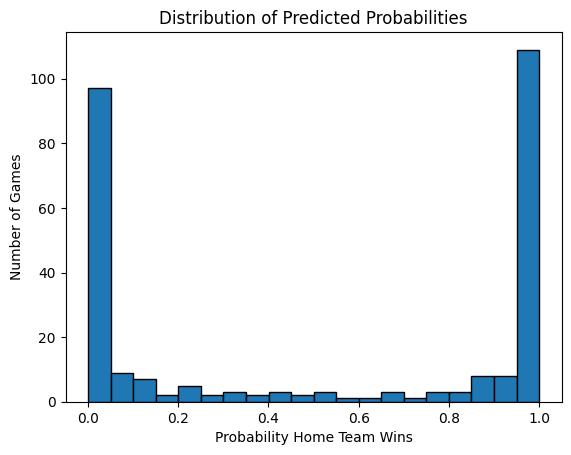

In [43]:
import matplotlib.pyplot as plt

plt.hist(probabilities, bins=20, edgecolor='black')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Probability Home Team Wins')
plt.ylabel('Number of Games')
plt.show()